In [207]:
import openai
import config  # Import your config.py file
import pandas as pd
import numpy as np
import pickle
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import json

# Set up the OpenAI API key from the config.py file
openai.api_key = config.api_key 

In [370]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_model_response(prompt, engine="gpt-3.5-turbo"):
    
    messages = [
        {"role": "system", "content": "This is the system message"},
        {"role": "user", "content":prompt}
    ]

    response = openai.ChatCompletion.create(
        model=engine,
        messages=messages,
        max_tokens=2000,
        temperature = 0.2,
        top_p = 0.9,
    )

    return response['choices'][0]['message']['content'].strip()

def identify_gics_classes(df, class_list):

    temp_df = df.copy()
    temp_df['classes'] = ""
    for i in range(0, temp_df.shape[0]):

        biography = temp_df.at[i,'Biography']

        prompt = f"""

                    Read the list of Global Industry Classification Standard  (GICS) industry classes shown surrounded by 4 colon's below
                    ::::
                    {class_list}
                    ::::

                    Now read the the biography below surrounded by 3 colons, return a python list of GICS classes that most appropriately match the text
                    :::
                    {biography}
                    :::
                    the return string should be in the form shown below and should contain at least 1 entry
                    [entry_1, entry_2,.. entry_n]
                    """

        temp_df.loc[i, 'classes'] = get_model_response(prompt, engine="gpt-3.5-turbo")

    return temp_df

    
path_folder = './data/cities_json/London'

In [3]:
all_files = os.listdir(path_folder)

In [4]:
temp_dict = load_pickle_file(path_folder+'/'+all_files[1])

In [112]:
data_root = './data/cities_json'
bios_path = './data/all_bios_embeddings.csv'
missing_bios_path = './data/missing_bios.csv'
if os.path.exists(bios_path):
    # Load the existing CSV if it exists
    all_bios_df = pd.read_csv(bios_path)
    #this conversion takes about 10 secs. a better storage method may be preferable aka, index = file name columns are numeric embeddings
    all_bios_df['embedding'] = all_bios_df['embedding'].apply(ast.literal_eval)
    missing_bio_df = pd.read_csv(missing_bios_path)
else:
    # Run the code to generate DataFrames a and b
    all_bios_df = []
    for path in os.listdir(data_root ):

        all_files = os.listdir(data_root +'/' + path)

        for file in all_files:

            temp_dict = load_pickle_file(data_root +'/' + path +'/'+file)

            if 'biography' not in temp_dict:
                temp_dict['biography'] = pd.DataFrame({'Biography':[""]})
            
            temp_df = temp_dict['biography']
            temp_df['city'] = path
            temp_df['file'] = file
            temp_df['file'] = temp_df['file'].replace('.pkl', "")

            all_bios_df.append(temp_df)


    all_bios_df = pd.concat(all_bios_df, ignore_index=True)
    all_bios_df = all_bios_df[['file', 'city','Biography']]

    all_bios_df['no_bio']=(all_bios_df['Biography'].apply(len)<50)
    missing_bio_df = all_bios_df.loc[all_bios_df['no_bio'] ].copy().drop('no_bio', axis = 1)

    all_bios_df = all_bios_df.loc[~all_bios_df['no_bio'] ].drop('no_bio', axis = 1)

    #this takes about 12 minutes and costs money, only run when necessary!!!
    all_bios_df['embedding'] = all_bios_df['Biography'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

    missing_bio_df.to_csv(missing_bios_path, index = False)
    all_bios_df.to_csv(bios_path, index = False)


In [97]:
all_bios_df.groupby(['city']).size()

city
Frankfurt                 103
Hong Kong                 384
Johannesburg              124
Lagos                     246
London                    394
Mexico City               104
New York                  389
Rio de Janeiro             52
San Francisco Bay Area    390
Sydney                    316
dtype: int64

In [172]:
gics_embeddings_path = './data/gics_embeddings.csv'
if os.path.exists(gics_embeddings_path):
    # Load the existing CSV if it exists
    gics_embeddings_df = pd.read_csv(gics_embeddings_path)
    gics_embeddings_df = gics_embeddings_df['embedding'].apply(ast.literal_eval)

else:
    gics_embeddings_df = pd.read_csv('./data/gics-map-2018.csv')
    gics_embeddings_df['embedding_desc'] = gics_embeddings_df['SubIndustryDescription'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
    gics_embeddings_df['embedding'] = gics_embeddings_df['SubIndustry'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
    gics_embeddings_df['token_count'] = gics_embeddings_df['SubIndustryDescription'].apply(lambda x: len(encoding.encode(x)))
    gics_embeddings_df.to_csv(gics_embeddings_path, index=False)



In [186]:

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")



In [156]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(df_A, df_B):
    # Assuming that the embeddings in both dataframes are stored in a column named 'embeddings'
    embeddings_A = np.stack(df_A['embedding'].values)
    embeddings_B = np.stack(df_B['embedding'].values)
    
    # Calculate cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings_A, embeddings_B)
    
    return cosine_sim_matrix


def compute_similarity_statistics(cosine_sim_matrix, min = 0, max = 1, num_cutoffs=1000):
    cutoffs = np.linspace(min, max, num=num_cutoffs)
    
    statistics = {
        'Cutoff': [],
        'Maximum': [],
        'Minimum': [],
        'Mean': [],
        'Median': [],
        'Standard Deviation': []
    }

    for cutoff in cutoffs:
        row_sums = np.sum(cosine_sim_matrix >= cutoff, axis=1)
        if row_sums.any():
            statistics['Cutoff'].append(cutoff)
            statistics['Maximum'].append(np.max(row_sums))
            statistics['Minimum'].append(np.min(row_sums))
            statistics['Mean'].append(np.mean(row_sums))
            statistics['Median'].append(np.median(row_sums))
            statistics['Standard Deviation'].append(np.std(row_sums))

    result_df = pd.DataFrame(statistics)
    return result_df

In [173]:
test = compute_cosine_similarity(all_bios_df, gics_embeddings_df)

In [182]:
test2 = compute_similarity_statistics(test, 0.7, 0.73, num_cutoffs=1000)
test2.loc[test2['Minimum']==1].sort_values('Cutoff', ascending=False).head()

,Cutoff,Maximum,Minimum,Mean,Median,Standard Deviation
832,0.724985,156,1,76.397282,76.0,31.895257
831,0.724955,156,1,76.501599,76.0,31.898154
830,0.724925,156,1,76.601519,76.0,31.901726
829,0.724895,156,1,76.700639,76.0,31.906029
828,0.724865,156,1,76.796962,76.0,31.902121


<Axes: xlabel='Cutoff', ylabel='Minimum'>

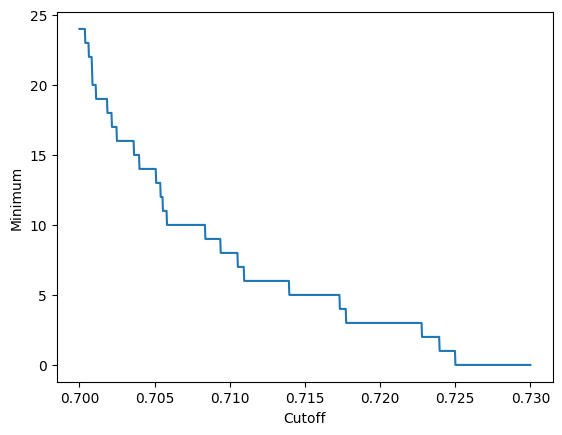

In [181]:
sns.lineplot(data = test2, x = 'Cutoff', y = 'Minimum')

# Perform auto classification of the gics classes

In [378]:
#prevents the calls to gpt being re-run unnecessarily
if 'classes' not in all_bios_df.columns:
    all_bios_df = identify_gics_classes(all_bios_df, str(gics_embeddings_df['Industry'].unique().tolist()))
    all_bios_df.to_csv(bios_path, index = False)


ttt


# Create a binary multi-label dataframe

In [375]:
binary_data = {}

# Iterate through each class in the original list and construct the binary data
for class_name in gics_embeddings_df['Industry'].unique().tolist():
    binary_data[class_name] = all_bios_df['classes'].apply(lambda x: 1 if class_name in x else 0)

binary_df = pd.DataFrame(binary_data)
